<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Classification of Subreddit Posts (Part 2 of 2)

This is the second notebook of the "Project 3: Classification of Subreddit Posts" where the following process will be discussed:
- Dataset Cleaning
- Explanatory Data Anaylsis (EDA)
- Modelling, and
- Conclusion & Recommendation

## 1. Importing Libraries

In [1]:
import requests
import string
import re
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# instantiate the lemmatizer and stopwords
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

# set the max columns to none
pd.set_option('display.max_columns', None)

## 2. Cleaning Dataset

The dataset that is scrapped was further cleaned. We first filter the dataset to certain columns is relevant with our analysis and also check any empty cells in the dataset.  
Next we also remove any duplicates row based on the `title` and `selftext` column to avoid unnecessary noise.  

The following step, a new column `text` is created with the `title` and `selftext` value and the column is further check if any unnecessary string such as http/www address and html punctuations exist.

In [2]:
data = pd.read_csv('data/df_tea&coffee_220524.csv')

In [3]:
data.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_template_id,link_flair_text,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,post_hint,preview,removed_by_category,thumbnail_height,thumbnail_width,url_overridden_by_dest,gallery_data,is_gallery,media_metadata,media,media_embed,secure_media,secure_media_embed,crosspost_parent,crosspost_parent_list,author_flair_template_id,author_flair_text_color,author_flair_background_color,banned_by,poll_data,author_cakeday,suggested_sort,distinguished,call_to_action,category
0,[],False,cobaltjay,NaN,[],NaN,text,t2_4i4nw2ff,False,False,False,[],False,False,1653377746,self.tea,https://www.reddit.com/r/tea/comments/uwlc69/w...,{},uwlc69,False,True,False,False,False,True,True,False,NaN,reco,"[{'e': 'text', 't': 'Recommendation'}]",7863b26c-9f57-11e4-a2b0-22000bc1889b,Recommendation,dark,richtext,False,False,True,0,0,False,all_ads,/r/tea/comments/uwlc69/whats_your_favourite_br...,False,6,1653377757,1,I have recently started some new medication th...,True,False,False,tea,t5_2qq5e,659158,public,self,What's your favourite brand for decaf tea?,0,[],1.0,https://www.reddit.com/r/tea/comments/uwlc69/w...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,kibbles16,NaN,[],NaN,text,t2_m8mu0vez,False,False,False,[],False,False,1653372437,self.tea,https://www.reddit.com/r/tea/comments/uwk4pc/h...,{},uwk4pc,False,True,False,False,False,True,True,False,NaN,NaN,[],NaN,NaN,dark,text,False,False,True,0,0,False,all_ads,/r/tea/comments/uwk4pc/how_do_you_make_tea_tas...,False,6,1653372448,1,"I love tea, especially green and jasmine tea. ...",True,False,False,tea,t5_2qq5e,659124,public,self,How do you make tea taste refreshing?,0,[],1.0,https://www.reddit.com/r/tea/comments/uwk4pc/h...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,-___ari___-,NaN,[],NaN,text,t2_82epe397,False,False,False,[],False,False,1653364473,self.tea,https://www.reddit.com/r/tea/comments/uwi2xw/h...,{},uwi2xw,False,True,False,False,False,True,True,False,NaN,help,"[{'e': 'text', 't': 'Question/Help'}]",64c60b7e-9f57-11e4-adfe-22000b680aa5,Question/Help,dark,richtext,False,False,True,0,0,False,all_ads,/r/tea/comments/uwi2xw/how_is_the_first_flush_...,False,6,1653364483,1,"hi, just recently getting into specialty teas,...",True,False,False,tea,t5_2qq5e,659088,public,self,how is the first flush experience? is it that ...,0,[],1.0,https://www.reddit.com/r/tea/comments/uwi2xw/h...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,UsernameNumberThree,NaN,[],NaN,text,t2_fcgfe,False,False,False,[],False,False,1653350251,self.tea,https://www.reddit.com/r/tea/comments/uwdvoh/w...,{},uwdvoh,False,True,False,False,False,True,True,False,NaN,NaN,[],NaN,NaN,dark,text,False,False,True,0,0,False,all_ads,/r/tea/comments/uwdvoh/what_are_your_most_succ...,False,6,1653350262,1,I purchased some from a specialty shop in NYC....,True,False,False,tea,t5_2qq5e,659042,public,self,What are your most successful concoctions with...,0,[],1.0,https://www.reddit.com/r/tea/comments/uwdvoh/w...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [211]:
data.shape

(2442, 87)

In [4]:
data.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_css_class', 'link_flair_richtext', 'link_flair_template_id',
       'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked',
       'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_sub

We will choose the columns that are appropriate for our analysis

In [5]:
columns = ['author', 'created_utc', 'num_comments', 'title', 'selftext', 'subreddit']

In [6]:
data_clean = data[columns]
data_clean.head()

,author,created_utc,num_comments,title,selftext,subreddit
0,cobaltjay,1653377746,0,What's your favourite brand for decaf tea?,I have recently started some new medication th...,tea
1,kibbles16,1653372437,0,How do you make tea taste refreshing?,"I love tea, especially green and jasmine tea. ...",tea
2,-___ari___-,1653364473,0,how is the first flush experience? is it that ...,"hi, just recently getting into specialty teas,...",tea
3,UsernameNumberThree,1653350251,0,What are your most successful concoctions with...,I purchased some from a specialty shop in NYC....,tea
4,mkmkatreddit,1653336633,0,"Please help, is my Yixing teapot genuine?","Hi,\ncan someone please help me asses whether ...",tea


In [210]:
data_clean.isnull().sum().iloc[:-3]

author          0
created_utc     0
num_comments    0
title           0
selftext        0
subreddit       0
dtype: int64

There should be no empty cell since we have filtered them out during scraping process

### - Remove Duplicates

We are going to drop duplicates based on the title and selftext to avoid unnecessary noise

In [8]:
data_clean.drop_duplicates(subset=['title', 'selftext'], keep='first', inplace=True)

C:\Users\Adi H. Kusuma\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [9]:
data_clean

,author,created_utc,num_comments,title,selftext,subreddit
0,cobaltjay,1653377746,0,What's your favourite brand for decaf tea?,I have recently started some new medication th...,tea
1,kibbles16,1653372437,0,How do you make tea taste refreshing?,"I love tea, especially green and jasmine tea. ...",tea
2,-___ari___-,1653364473,0,how is the first flush experience? is it that ...,"hi, just recently getting into specialty teas,...",tea
3,UsernameNumberThree,1653350251,0,What are your most successful concoctions with...,I purchased some from a specialty shop in NYC....,tea
4,mkmkatreddit,1653336633,0,"Please help, is my Yixing teapot genuine?","Hi,\ncan someone please help me asses whether ...",tea
...,...,...,...,...,...,...
2437,jack_ftw,1650038368,0,"""Work perk"" mystery bag","A friend got a bag of coffee from work as a ""p...",Coffee
2438,Classic_Ad9996,1650035557,0,Bonavita Carafe,"I have a Bonavita 8-Cup One-Touch, with Therma...",Coffee
2439,ResponsibilityNo6435,1650035176,0,Favorite coffee brewing from first to last,"Okay, everyone has an opinion, especially abou...",Coffee
2440,pnwbg,1650033804,0,Broke my Kalita Wave,I broke my glass Kalita wave the day after I r...,Coffee


Remarks: 53 rows are deleted after the drop duplicates function is enacted

### - Removing Unnecessary Words from the Text

We create new column `text` based on `title` and `selftext`columns

In [10]:
data_clean['text'] = data_clean['title'] + ' ' + data_clean['selftext']

C:\Users\ADIH~1.KUS\AppData\Local\Temp/ipykernel_24392/584891190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['text'] = data_clean['title'] + ' ' + data_clean['selftext']


In [11]:
data_clean

,author,created_utc,num_comments,title,selftext,subreddit,text
0,cobaltjay,1653377746,0,What's your favourite brand for decaf tea?,I have recently started some new medication th...,tea,What's your favourite brand for decaf tea? I h...
1,kibbles16,1653372437,0,How do you make tea taste refreshing?,"I love tea, especially green and jasmine tea. ...",tea,How do you make tea taste refreshing? I love t...
2,-___ari___-,1653364473,0,how is the first flush experience? is it that ...,"hi, just recently getting into specialty teas,...",tea,how is the first flush experience? is it that ...
3,UsernameNumberThree,1653350251,0,What are your most successful concoctions with...,I purchased some from a specialty shop in NYC....,tea,What are your most successful concoctions with...
4,mkmkatreddit,1653336633,0,"Please help, is my Yixing teapot genuine?","Hi,\ncan someone please help me asses whether ...",tea,"Please help, is my Yixing teapot genuine? Hi,\..."
...,...,...,...,...,...,...,...
2437,jack_ftw,1650038368,0,"""Work perk"" mystery bag","A friend got a bag of coffee from work as a ""p...",Coffee,"""Work perk"" mystery bag A friend got a bag of ..."
2438,Classic_Ad9996,1650035557,0,Bonavita Carafe,"I have a Bonavita 8-Cup One-Touch, with Therma...",Coffee,Bonavita Carafe I have a Bonavita 8-Cup One-To...
2439,ResponsibilityNo6435,1650035176,0,Favorite coffee brewing from first to last,"Okay, everyone has an opinion, especially abou...",Coffee,Favorite coffee brewing from first to last Oka...
2440,pnwbg,1650033804,0,Broke my Kalita Wave,I broke my glass Kalita wave the day after I r...,Coffee,Broke my Kalita Wave I broke my glass Kalita w...


The `text` column is filtered through if there is any http/www address or any html punctuation

In [12]:
data_clean['text']  = data_clean['text'].str.replace(r'http.+', '', regex=True)
data_clean['text']  = data_clean['text'].str.replace(r'www.+', '', regex=True)
data_clean['text']  = data_clean['text'].str.replace('\n', ' ')
data_clean['text']  = data_clean['text'].str.replace('&#x200b', ' ')
data_clean['text']  = data_clean['text'].str.replace('&amp;', ' ')

C:\Users\ADIH~1.KUS\AppData\Local\Temp/ipykernel_24392/1296742667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['text']  = data_clean['text'].str.replace(r'http.+', '', regex=True)
C:\Users\ADIH~1.KUS\AppData\Local\Temp/ipykernel_24392/1296742667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['text']  = data_clean['text'].str.replace(r'www.+', '', regex=True)
C:\Users\ADIH~1.KUS\AppData\Local\Temp/ipykernel_24392/1296742667.py:3: SettingWithCopyWarning: 
A value is trying to

In [13]:
len(data_clean[data_clean['text'] == ''])

0

There are no empty text in the dataset, we will move on to next step

In [14]:
data_clean

,author,created_utc,num_comments,title,selftext,subreddit,text
0,cobaltjay,1653377746,0,What's your favourite brand for decaf tea?,I have recently started some new medication th...,tea,What's your favourite brand for decaf tea? I h...
1,kibbles16,1653372437,0,How do you make tea taste refreshing?,"I love tea, especially green and jasmine tea. ...",tea,How do you make tea taste refreshing? I love t...
2,-___ari___-,1653364473,0,how is the first flush experience? is it that ...,"hi, just recently getting into specialty teas,...",tea,how is the first flush experience? is it that ...
3,UsernameNumberThree,1653350251,0,What are your most successful concoctions with...,I purchased some from a specialty shop in NYC....,tea,What are your most successful concoctions with...
4,mkmkatreddit,1653336633,0,"Please help, is my Yixing teapot genuine?","Hi,\ncan someone please help me asses whether ...",tea,"Please help, is my Yixing teapot genuine? Hi, ..."
...,...,...,...,...,...,...,...
2437,jack_ftw,1650038368,0,"""Work perk"" mystery bag","A friend got a bag of coffee from work as a ""p...",Coffee,"""Work perk"" mystery bag A friend got a bag of ..."
2438,Classic_Ad9996,1650035557,0,Bonavita Carafe,"I have a Bonavita 8-Cup One-Touch, with Therma...",Coffee,Bonavita Carafe I have a Bonavita 8-Cup One-To...
2439,ResponsibilityNo6435,1650035176,0,Favorite coffee brewing from first to last,"Okay, everyone has an opinion, especially abou...",Coffee,Favorite coffee brewing from first to last Oka...
2440,pnwbg,1650033804,0,Broke my Kalita Wave,I broke my glass Kalita wave the day after I r...,Coffee,Broke my Kalita Wave I broke my glass Kalita w...


## 3. Exploratory Data Analysis

In this stage, we explored the data based on the number of comments as well as the text of each posts. The texts were analysed using CountVectorizer and TfidfVectorizer based on the unigram, bigram and tigram. After the first analysis, we found some posts from the moderator and decided to remove them. Some new stopwords were also added to have a better understanding of the data. The newly cleaned dataset was analysed again to check for the top word indicator

### - Number of Comments

The number of comments were grouped by the subreddit for analysis

In [15]:
group = data_clean.groupby(by='subreddit')

In [16]:
group['num_comments'].sum()

subreddit
Coffee      2
tea       597
Name: num_comments, dtype: int64

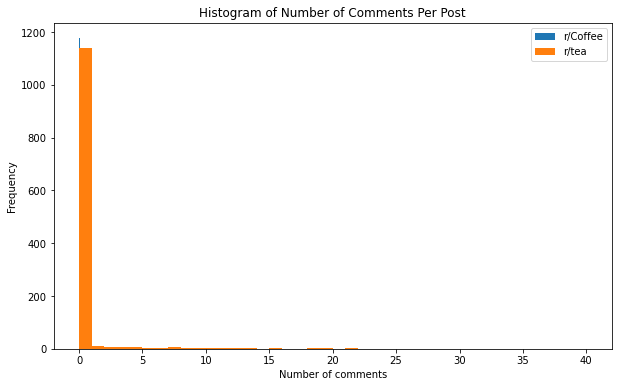

In [205]:
group['num_comments'].plot(kind='hist', bins=40, figsize=(10,6))

plt.title('Histogram of Number of Comments Per Post')
plt.xlabel('Number of comments')
plt.legend(['r/Coffee','r/tea'])

Observation: The r/tea subreddit clearly have more comments compared to r/Coffee subreddit. This may implies that the posts in r/tea subreddit tends to be discussion thus the number of comments found are bigger than the r/Coffee subreddit

### - Text

The texts were analysed using CountVectorizer and TfidfVectorizer. Before inputting the columns to the transformer model, the texts were further filter by removing the punctuation, tokenization and lemmatization in order for the model to have a better dataset that is easily interpreted.

Let's convert the subreddit into binary labels:
- tea : 0
- coffee : 1

In [23]:
data_clean['subreddit'] = data_clean['subreddit'].map({'tea':0, 'Coffee':1})

C:\Users\ADIH~1.KUS\AppData\Local\Temp/ipykernel_24392/58976592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['subreddit'] = data_clean['subreddit'].map({'tea':0, 'Coffee':1})


In [24]:
data_clean

,author,created_utc,num_comments,title,selftext,subreddit,text
0,cobaltjay,1653377746,0,What's your favourite brand for decaf tea?,I have recently started some new medication th...,0,What's your favourite brand for decaf tea? I h...
1,kibbles16,1653372437,0,How do you make tea taste refreshing?,"I love tea, especially green and jasmine tea. ...",0,How do you make tea taste refreshing? I love t...
2,-___ari___-,1653364473,0,how is the first flush experience? is it that ...,"hi, just recently getting into specialty teas,...",0,how is the first flush experience? is it that ...
3,UsernameNumberThree,1653350251,0,What are your most successful concoctions with...,I purchased some from a specialty shop in NYC....,0,What are your most successful concoctions with...
4,mkmkatreddit,1653336633,0,"Please help, is my Yixing teapot genuine?","Hi,\ncan someone please help me asses whether ...",0,"Please help, is my Yixing teapot genuine? Hi, ..."
...,...,...,...,...,...,...,...
2437,jack_ftw,1650038368,0,"""Work perk"" mystery bag","A friend got a bag of coffee from work as a ""p...",1,"""Work perk"" mystery bag A friend got a bag of ..."
2438,Classic_Ad9996,1650035557,0,Bonavita Carafe,"I have a Bonavita 8-Cup One-Touch, with Therma...",1,Bonavita Carafe I have a Bonavita 8-Cup One-To...
2439,ResponsibilityNo6435,1650035176,0,Favorite coffee brewing from first to last,"Okay, everyone has an opinion, especially abou...",1,Favorite coffee brewing from first to last Oka...
2440,pnwbg,1650033804,0,Broke my Kalita Wave,I broke my glass Kalita wave the day after I r...,1,Broke my Kalita Wave I broke my glass Kalita w...


In [25]:
# we will exclude the punctuation in the stopwords list to match with our function workflow
stopwords = [ ''.join(letter for letter in word if letter not in string.punctuation) for word in stopwords]

In [26]:
def clean_text(text):
    text = "".join([word.lower() if word not in string.punctuation else ' ' for word in text ])
    # \W matches any non-word character (equivalent to [^a-zA-Z0-9_]). This does not include spaces i.e. \s
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    
    # apply lemmatize and stopwords exclusion within the same step
    text = ' '.join([wn.lemmatize(word) for word in tokens if word not in stopwords])
    return text

In [27]:
# apply the clean_text function to the 'text' column
data_clean['text_cleaned_lemmatize'] = data_clean['text'].apply(clean_text)

C:\Users\ADIH~1.KUS\AppData\Local\Temp/ipykernel_24392/616010759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['text_cleaned_lemmatize'] = data_clean['text'].apply(clean_text)


In [28]:
data_clean

,author,created_utc,num_comments,title,selftext,subreddit,text,text_cleaned_lemmatize
0,cobaltjay,1653377746,0,What's your favourite brand for decaf tea?,I have recently started some new medication th...,0,What's your favourite brand for decaf tea? I h...,favourite brand decaf tea recently started new...
1,kibbles16,1653372437,0,How do you make tea taste refreshing?,"I love tea, especially green and jasmine tea. ...",0,How do you make tea taste refreshing? I love t...,make tea taste refreshing love tea especially ...
2,-___ari___-,1653364473,0,how is the first flush experience? is it that ...,"hi, just recently getting into specialty teas,...",0,how is the first flush experience? is it that ...,first flush experience good hi recently gettin...
3,UsernameNumberThree,1653350251,0,What are your most successful concoctions with...,I purchased some from a specialty shop in NYC....,0,What are your most successful concoctions with...,successful concoction butterfly pea flower tea...
4,mkmkatreddit,1653336633,0,"Please help, is my Yixing teapot genuine?","Hi,\ncan someone please help me asses whether ...",0,"Please help, is my Yixing teapot genuine? Hi, ...",please help yixing teapot genuine hi someone p...
...,...,...,...,...,...,...,...,...
2437,jack_ftw,1650038368,0,"""Work perk"" mystery bag","A friend got a bag of coffee from work as a ""p...",1,"""Work perk"" mystery bag A friend got a bag of ...",work perk mystery bag friend got bag coffee w...
2438,Classic_Ad9996,1650035557,0,Bonavita Carafe,"I have a Bonavita 8-Cup One-Touch, with Therma...",1,Bonavita Carafe I have a Bonavita 8-Cup One-To...,bonavita carafe bonavita 8 cup one touch therm...
2439,ResponsibilityNo6435,1650035176,0,Favorite coffee brewing from first to last,"Okay, everyone has an opinion, especially abou...",1,Favorite coffee brewing from first to last Oka...,favorite coffee brewing first last okay everyo...
2440,pnwbg,1650033804,0,Broke my Kalita Wave,I broke my glass Kalita wave the day after I r...,1,Broke my Kalita Wave I broke my glass Kalita w...,broke kalita wave broke glass kalita wave day ...


We will first check what is the most common words in each of the subreddit

In [29]:
X_tea = data_clean[data_clean['subreddit'] == 0]['text_cleaned_lemmatize']
X_coffee = data_clean[data_clean['subreddit'] == 1]['text_cleaned_lemmatize']

#### -> Count Vectorizer

Count Vectorizer transforms our dataset into a structured dataset based on number of counts of the words as a whole which is more intepretable for the machine.  
The process include:
- Dropping Punctuation from the text
- Tokenising the text
- Lemmatizing the text
- Fit the model to the dataset
- Convert to pandas dataframe for plotting purposes

In [30]:
# function to create subplots of barplot
def subplot_barplot(X1, X2, sub1, sub2, ngram, ngram_type, method):
      
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True, figsize=(15,10))
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    if method == 'cvec':
        mthd = '(Count Vectorizer)'
    elif method == 'tfidf':
        mthd = '(TF-IDF)'
        
    X1_df = vectorizer_df(X1, sub1, ngram, method) 
    X1_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], color='g')
    ax[0].set_title((sub1 + ' Subreddit Top ' + ngram_type + ' Words ' + mthd))
    ax[0].set_ylabel('word')
    ax[0].set_xlabel('count')
    
    X2_df = vectorizer_df(X2, sub2, ngram, method)
    X2_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], color='r')
    ax[1].set_title((sub2 + ' Subreddit Top ' + ngram_type + ' Words ' + mthd))
    ax[1].set_ylabel('word')
    ax[1].set_xlabel('count')
    
    fig.tight_layout()

In [31]:
# function to vectorize the X list and return a dataframe
def vectorizer_df(X, sub, ngram, method):
    # to classify the method
    if method == 'cvec':
        vec = CountVectorizer(ngram_range=ngram)
    elif method == 'tfidf':
        vec = TfidfVectorizer(ngram_range=ngram)
    
    # fit and transform the X to the vectorizer
    X = vec.fit_transform(X)
    
    # print the shape of the matrix
    print('The shape of the', sub, 'matrix :', X.shape)
    
    X_df = pd.DataFrame(X.todense(), columns=vec.get_feature_names())
    
    return X_df

##### + Unigram

The shape of the r/tea matrix : (1211, 6280)
The shape of the r/Coffee matrix : (1178, 6870)


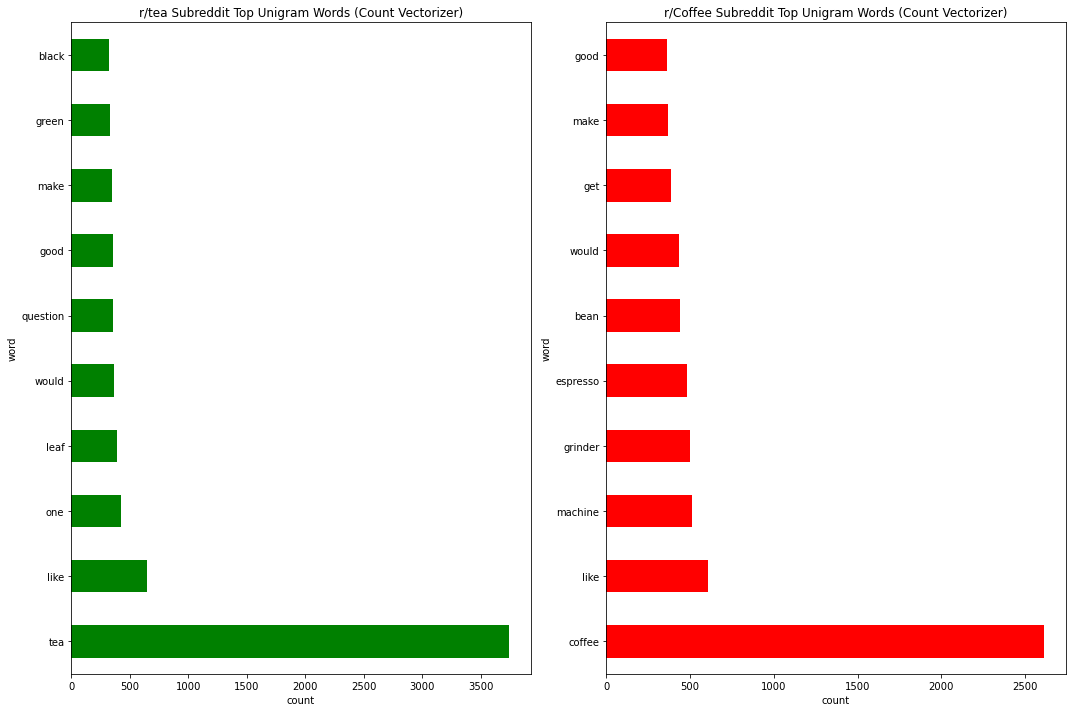

In [32]:
subplot_barplot(X_tea, X_coffee, 'r/tea', 'r/Coffee', (1,1), 'Unigram', 'cvec')

Observation: The top indicator word for both r/tea and r/Coffee subreddit is unsuprisingly tea and coffee. The count is quite huge and the word itself is too obvious, thus we decided to remove it from consideration. The other word indicators are somehow not reflecting the subreddit title.

##### + Bigram

The shape of the r/tea matrix : (1211, 37322)
The shape of the r/Coffee matrix : (1178, 45521)


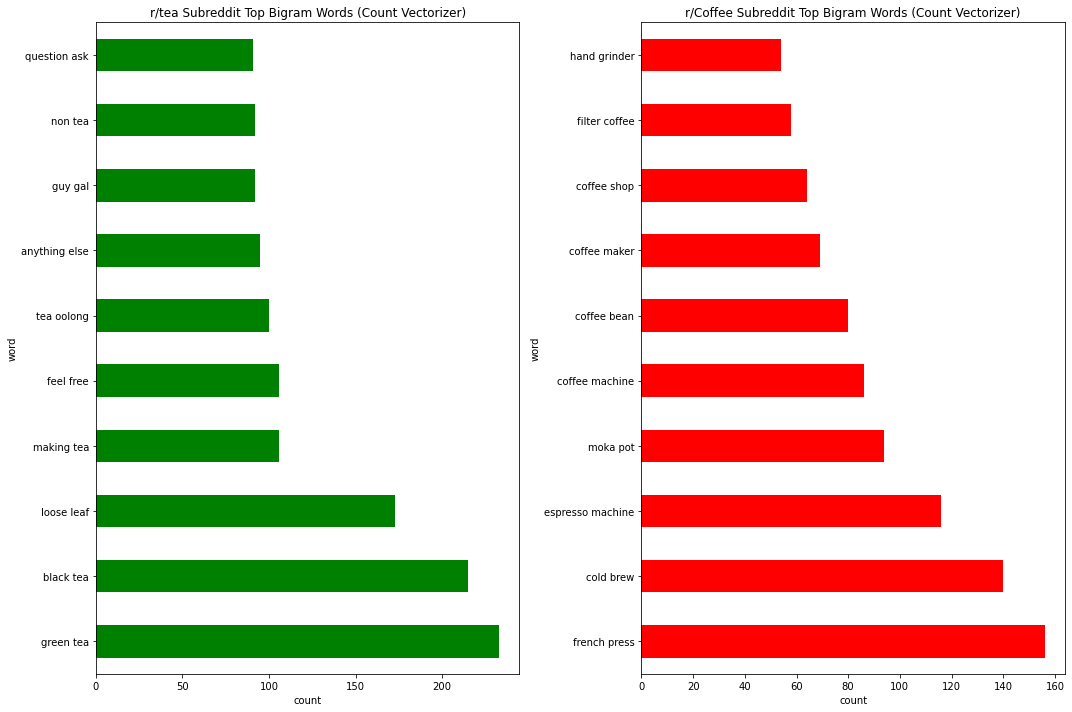

In [33]:
subplot_barplot(X_tea, X_coffee, 'r/tea', 'r/Coffee', (2,2), 'Bigram', 'cvec')

Remarks: As for the bigram, the top 3 words are very indicative of the subreddit. But we need to check again after we drop the tea and coffee word.  
As of the trend, for r/tea, it mainly consists of the type of teas while r/Coffee talks ore about the technique for coffee making.  
There is one bigram words in tea that is interesting which is 'guy gal' that need to be further checked.

##### + Trigram

The shape of the r/tea matrix : (1211, 46939)
The shape of the r/Coffee matrix : (1178, 56377)


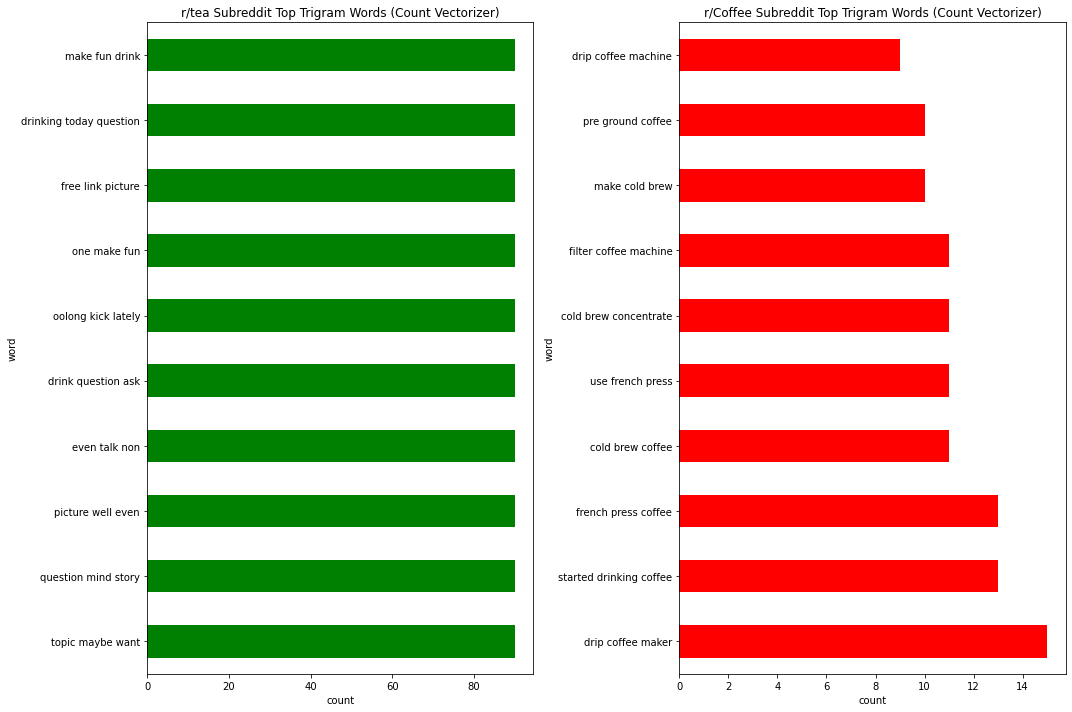

In [34]:
subplot_barplot(X_tea, X_coffee, 'r/tea', 'r/Coffee', (3,3), 'Trigram', 'cvec')

Remarks: For the r/tea subreddit, the top trigram indicator has very little correlative link with tea while the r/Coffee top trigram is still relatable but the count is relative low compared to other unigram and trigram, thus it may have little effect on the classification process

#### -> TF-IDF (Term Frequency - Inverse Document Frequency)

We will check the top words of each subreddit as per the count vectorize. The unigram, bigram and trigram will be evaluated as well.  
TF-IDF will be based on the term frequency with the inverse relation of document frequency. We wanted to compare with the Count Vectorizer method whether it will yield the same result.

##### + Unigram

The shape of the r/tea matrix : (1211, 6280)
The shape of the r/Coffee matrix : (1178, 6870)


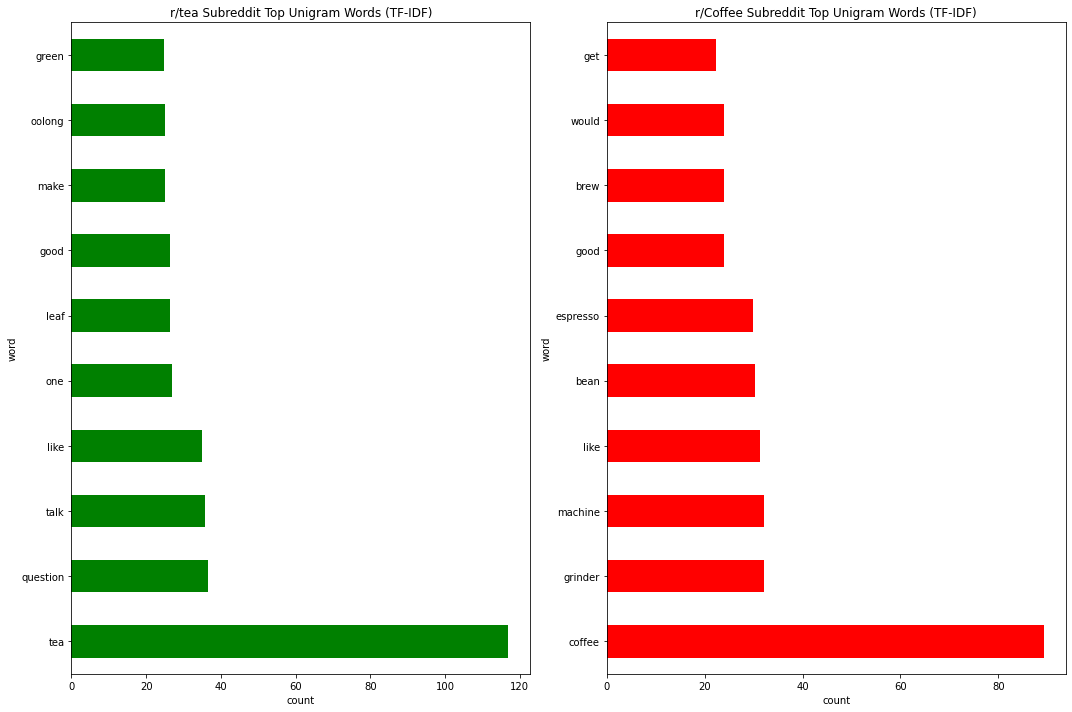

In [35]:
subplot_barplot(X_tea, X_coffee, 'r/tea', 'r/Coffee', (1,1), 'Unigram', 'tfidf')

##### + Bigram

The shape of the r/tea matrix : (1211, 37322)
The shape of the r/Coffee matrix : (1178, 45521)


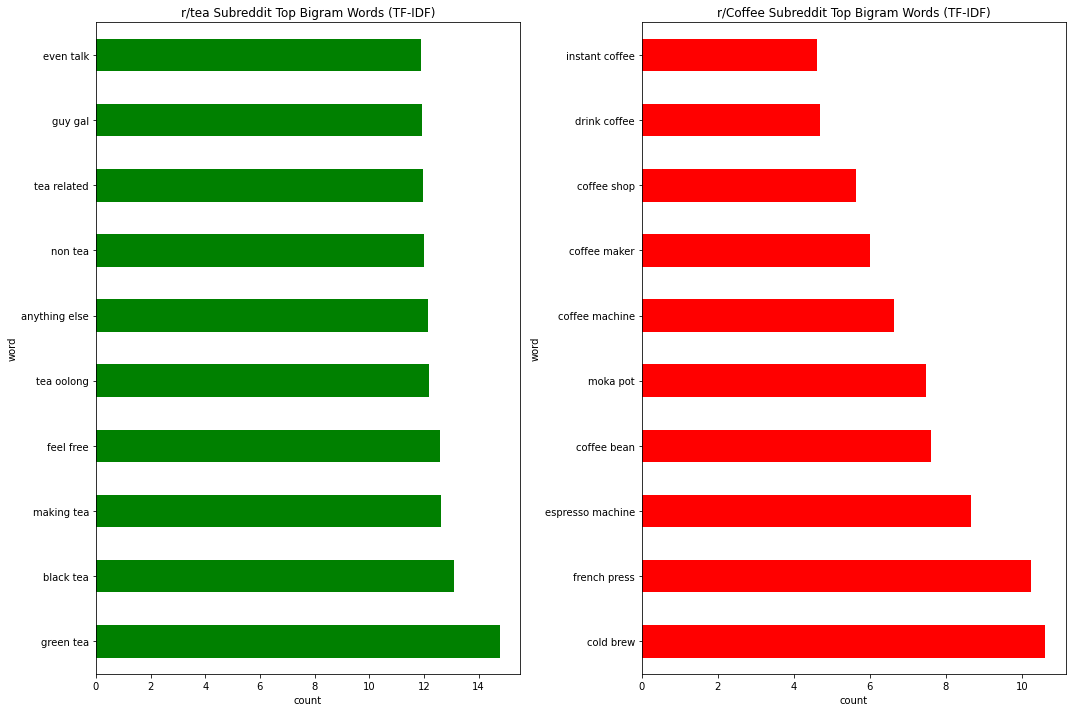

In [36]:
subplot_barplot(X_tea, X_coffee, 'r/tea', 'r/Coffee', (2,2), 'Bigram', 'tfidf')

##### + Trigram

The shape of the r/tea matrix : (1211, 46939)
The shape of the r/Coffee matrix : (1178, 56377)


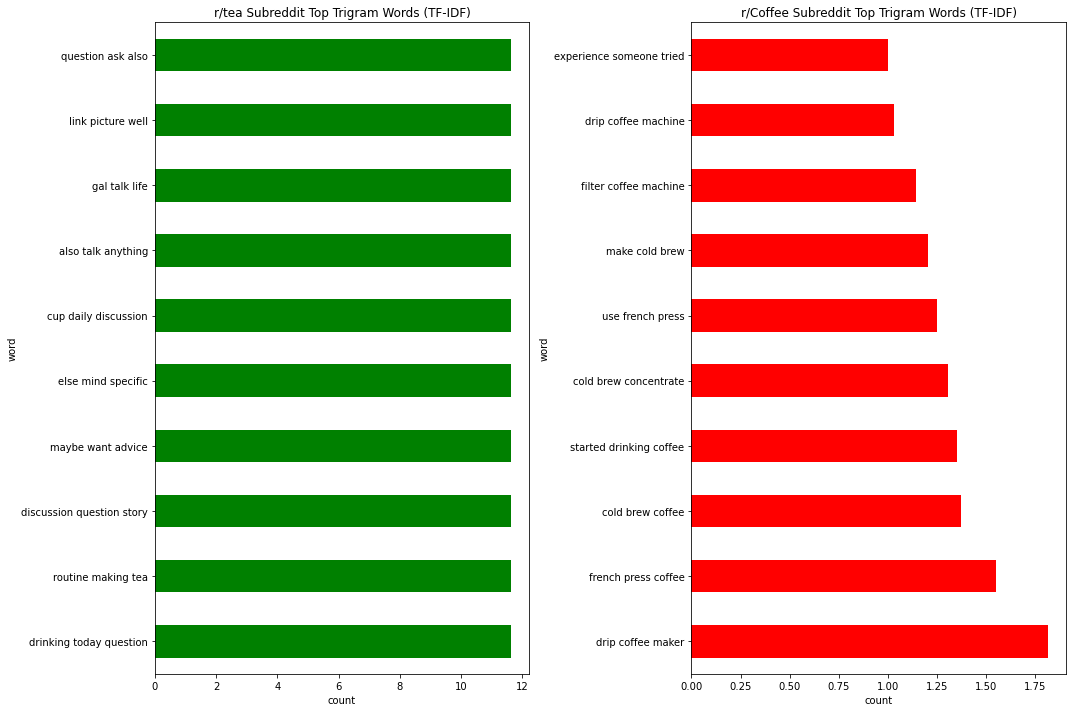

In [37]:
subplot_barplot(X_tea, X_coffee, 'r/tea', 'r/Coffee', (3,3), 'Trigram', 'tfidf')

Remarks: From the unigram, bigram and trigram top indicators, we can conclude that the words are similar to the words that are found with Count Vectorizer model

We tried to find the data that contains 'guy gal' :

In [38]:
data_clean[data_clean['text_cleaned_lemmatize'].str.contains('guy gal')]

,author,created_utc,num_comments,title,selftext,subreddit,text,text_cleaned_lemmatize
11,AutoModerator,1653303611,0,"What's in your cup? Daily discussion, question...",What are you drinking today? What questions h...,0,"What's in your cup? Daily discussion, question...",cup daily discussion question story may 23 202...
23,AutoModerator,1653217211,0,"What's in your cup? Daily discussion, question...",What are you drinking today? What questions h...,0,"What's in your cup? Daily discussion, question...",cup daily discussion question story may 22 202...
30,kenshinkan08,1653146858,0,are you a lowest steep time guy or longest?,"Just curious, I've been buying japanese gyokur...",0,are you a lowest steep time guy or longest? Ju...,lowest steep time guy longest curious buying j...
32,AutoModerator,1653130810,0,"What's in your cup? Daily discussion, question...",What are you drinking today? What questions h...,0,"What's in your cup? Daily discussion, question...",cup daily discussion question story may 21 202...
42,AutoModerator,1653044410,0,"What's in your cup? Daily discussion, question...",What are you drinking today? What questions h...,0,"What's in your cup? Daily discussion, question...",cup daily discussion question story may 20 202...
...,...,...,...,...,...,...,...,...
1149,AutoModerator,1645704016,9,"What's in your cup? Daily discussion, question...",What are you drinking today? What questions h...,0,"What's in your cup? Daily discussion, question...",cup daily discussion question story february 2...
1169,AutoModerator,1645617615,19,"What's in your cup? Daily discussion, question...",What are you drinking today? What questions h...,0,"What's in your cup? Daily discussion, question...",cup daily discussion question story february 2...
1184,AutoModerator,1645531218,40,"What's in your cup? Daily discussion, question...",What are you drinking today? What questions h...,0,"What's in your cup? Daily discussion, question...",cup daily discussion question story february 2...
1196,AutoModerator,1645444816,13,"What's in your cup? Daily discussion, question...",What are you drinking today? What questions h...,0,"What's in your cup? Daily discussion, question...",cup daily discussion question story february 2...


Remarks: There are some posts that is authored by AutoModerator and has the same content with different dates on different posts, we decided to remove the posts to remove noise

In [39]:
data_clean = data_clean[data_clean['author'] != 'AutoModerator']
data_clean

,author,created_utc,num_comments,title,selftext,subreddit,text,text_cleaned_lemmatize
0,cobaltjay,1653377746,0,What's your favourite brand for decaf tea?,I have recently started some new medication th...,0,What's your favourite brand for decaf tea? I h...,favourite brand decaf tea recently started new...
1,kibbles16,1653372437,0,How do you make tea taste refreshing?,"I love tea, especially green and jasmine tea. ...",0,How do you make tea taste refreshing? I love t...,make tea taste refreshing love tea especially ...
2,-___ari___-,1653364473,0,how is the first flush experience? is it that ...,"hi, just recently getting into specialty teas,...",0,how is the first flush experience? is it that ...,first flush experience good hi recently gettin...
3,UsernameNumberThree,1653350251,0,What are your most successful concoctions with...,I purchased some from a specialty shop in NYC....,0,What are your most successful concoctions with...,successful concoction butterfly pea flower tea...
4,mkmkatreddit,1653336633,0,"Please help, is my Yixing teapot genuine?","Hi,\ncan someone please help me asses whether ...",0,"Please help, is my Yixing teapot genuine? Hi, ...",please help yixing teapot genuine hi someone p...
...,...,...,...,...,...,...,...,...
2437,jack_ftw,1650038368,0,"""Work perk"" mystery bag","A friend got a bag of coffee from work as a ""p...",1,"""Work perk"" mystery bag A friend got a bag of ...",work perk mystery bag friend got bag coffee w...
2438,Classic_Ad9996,1650035557,0,Bonavita Carafe,"I have a Bonavita 8-Cup One-Touch, with Therma...",1,Bonavita Carafe I have a Bonavita 8-Cup One-To...,bonavita carafe bonavita 8 cup one touch therm...
2439,ResponsibilityNo6435,1650035176,0,Favorite coffee brewing from first to last,"Okay, everyone has an opinion, especially abou...",1,Favorite coffee brewing from first to last Oka...,favorite coffee brewing first last okay everyo...
2440,pnwbg,1650033804,0,Broke my Kalita Wave,I broke my glass Kalita wave the day after I r...,1,Broke my Kalita Wave I broke my glass Kalita w...,broke kalita wave broke glass kalita wave day ...


#### --> Count Vectorizer after Adjusted Stopwords

We will going to include the words that is very obvious in regards to either subreddits to the stopwords 

In [40]:
# list of additional stopwords to be appended to the stopwords list
add_stopwords = ['tea', 'teas', 'coffee', 'would', 'like']

In [41]:
stopwords.extend(add_stopwords)

In [42]:
stopwords[-5:]

['tea', 'teas', 'coffee', 'would', 'like']

In [43]:
data_clean['text_cleaned_lemmatize_v2'] = data_clean['text'].apply(clean_text)

C:\Users\ADIH~1.KUS\AppData\Local\Temp/ipykernel_24392/3792411941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['text_cleaned_lemmatize_v2'] = data_clean['text'].apply(clean_text)


In [44]:
data_clean.head()

,author,created_utc,num_comments,title,selftext,subreddit,text,text_cleaned_lemmatize,text_cleaned_lemmatize_v2
0,cobaltjay,1653377746,0,What's your favourite brand for decaf tea?,I have recently started some new medication th...,0,What's your favourite brand for decaf tea? I h...,favourite brand decaf tea recently started new...,favourite brand decaf recently started new med...
1,kibbles16,1653372437,0,How do you make tea taste refreshing?,"I love tea, especially green and jasmine tea. ...",0,How do you make tea taste refreshing? I love t...,make tea taste refreshing love tea especially ...,make taste refreshing love especially green ja...
2,-___ari___-,1653364473,0,how is the first flush experience? is it that ...,"hi, just recently getting into specialty teas,...",0,how is the first flush experience? is it that ...,first flush experience good hi recently gettin...,first flush experience good hi recently gettin...
3,UsernameNumberThree,1653350251,0,What are your most successful concoctions with...,I purchased some from a specialty shop in NYC....,0,What are your most successful concoctions with...,successful concoction butterfly pea flower tea...,successful concoction butterfly pea flower pur...
4,mkmkatreddit,1653336633,0,"Please help, is my Yixing teapot genuine?","Hi,\ncan someone please help me asses whether ...",0,"Please help, is my Yixing teapot genuine? Hi, ...",please help yixing teapot genuine hi someone p...,please help yixing teapot genuine hi someone p...


In [45]:
X_tea2 = data_clean[data_clean['subreddit'] == 0]['text_cleaned_lemmatize_v2']
X_coffee2 = data_clean[data_clean['subreddit'] == 1]['text_cleaned_lemmatize_v2']

Let's try again to check if there will be any difference on the transformer

##### + Unigram

The shape of the r/tea matrix : (1108, 6259)
The shape of the r/Coffee matrix : (1178, 6868)


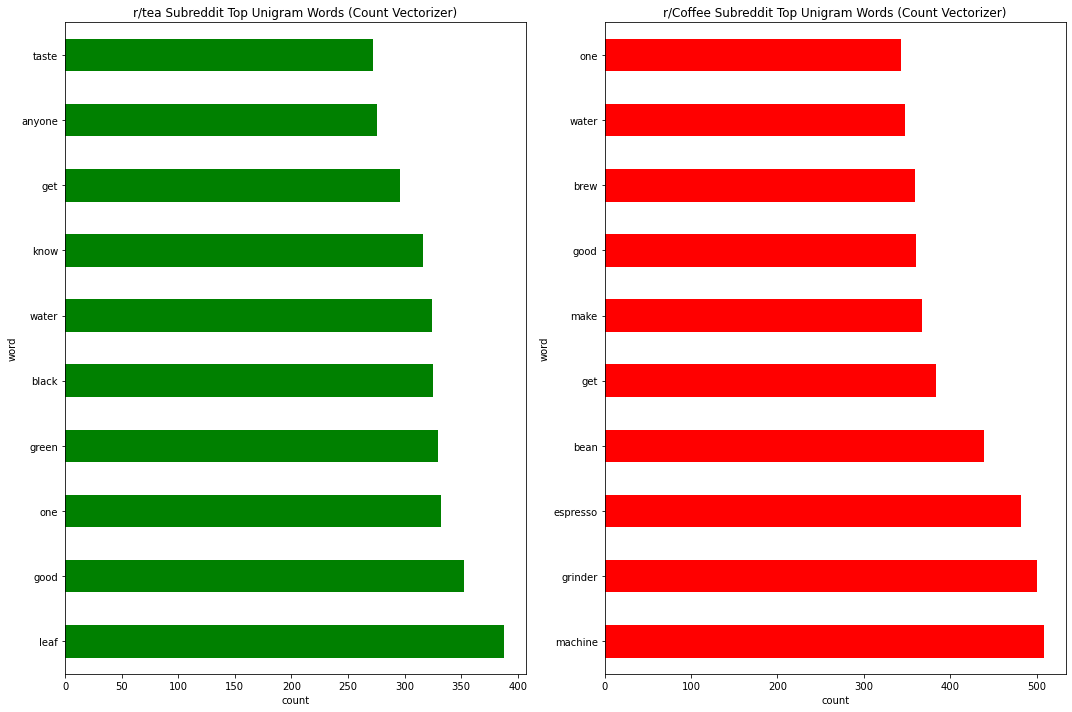

In [46]:
subplot_barplot(X_tea2, X_coffee2, 'r/tea', 'r/Coffee', (1,1), 'Unigram', 'cvec')

Remarks: After the additional stopwords, the unigram top words seems to be more relevant to the subreddit eventhough the top count dropped by at least 70%.  
The top indicator words for r/tea:
1. leaf
2. good
3. one
4. green
5. black

The top indicator words for r/Coffee:
1. machine
2. grinder
3. espresso
4. bean
5. get

##### + Bigram

The shape of the r/tea matrix : (1108, 37157)
The shape of the r/Coffee matrix : (1178, 45241)


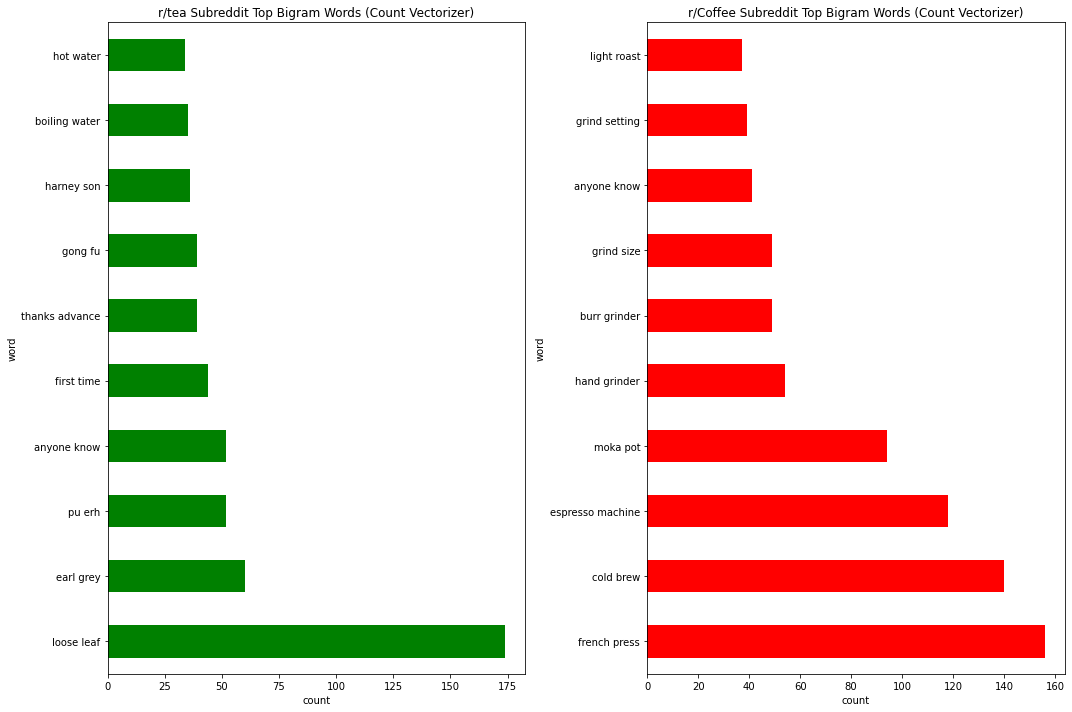

In [47]:
subplot_barplot(X_tea2, X_coffee2, 'r/tea', 'r/Coffee', (2,2), 'Bigram', 'cvec')

Remarks: The bigram words also improved by fair bit.  
The top bigram words for r/tea:
1. loose leaf
2. earl grey
3. pu erh
4. anyone know
5. first time

Most of the bigram in r/tea is the type of teas and there are many beginners that started to drinking tea.  
One interesting insight is the brand Harney & Sons are mentioned quite frequently

The top bigram words for r/Coffee:
1. french press
2. cold brew
3. espresso machine
4. moka pot
5. hand grinder

As per the unigram, the machine and technique still are the indicator words in r/Coffee

##### + Trigram

The shape of the r/tea matrix : (1108, 42914)
The shape of the r/Coffee matrix : (1178, 53314)


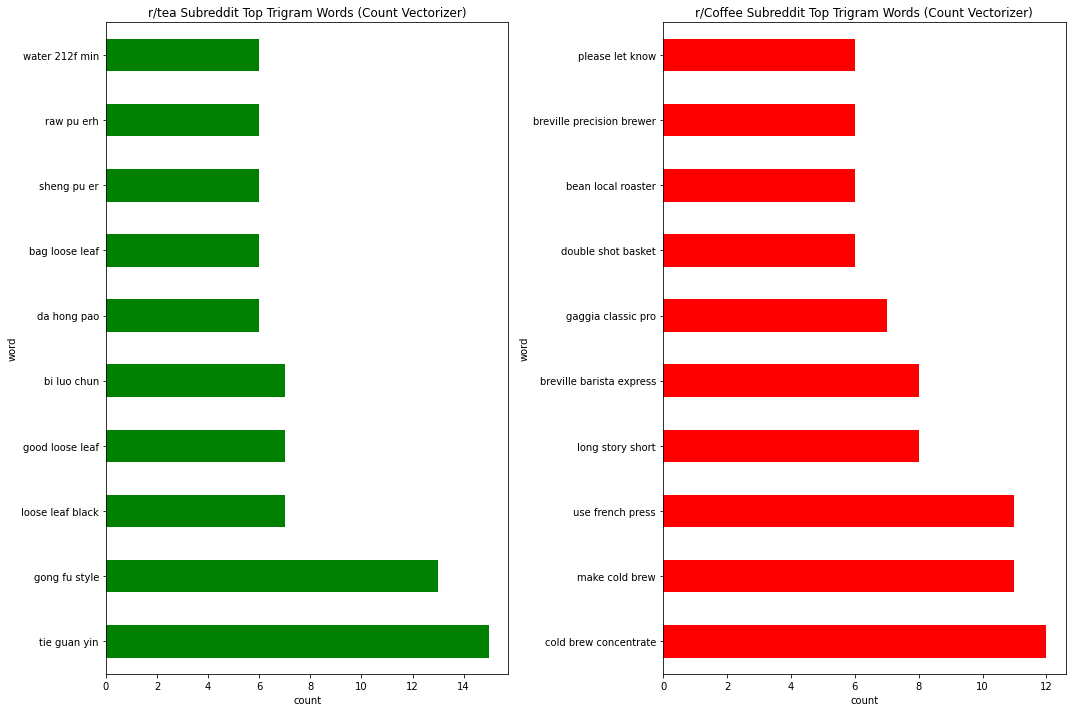

In [48]:
subplot_barplot(X_tea2, X_coffee2, 'r/tea', 'r/Coffee', (3,3), 'Trigram', 'cvec')

Remarks: Similar to bigram top indicator, the trigram top indicator words also has the similar style.

#### -> TF-IDF after Adjusted Stopwords

##### + Unigram

The shape of the r/tea matrix : (1108, 6259)
The shape of the r/Coffee matrix : (1178, 6868)


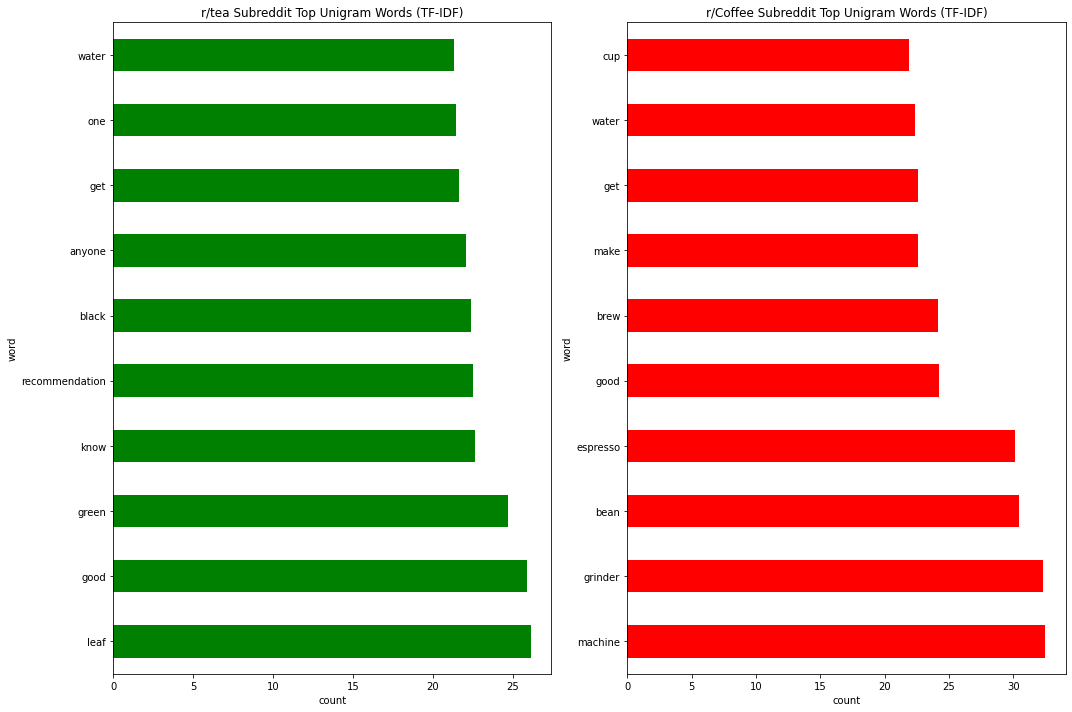

In [49]:
subplot_barplot(X_tea2, X_coffee2, 'r/tea', 'r/Coffee', (1,1), 'Unigram', 'tfidf')

##### + Bigram

The shape of the r/tea matrix : (1108, 37157)
The shape of the r/Coffee matrix : (1178, 45241)


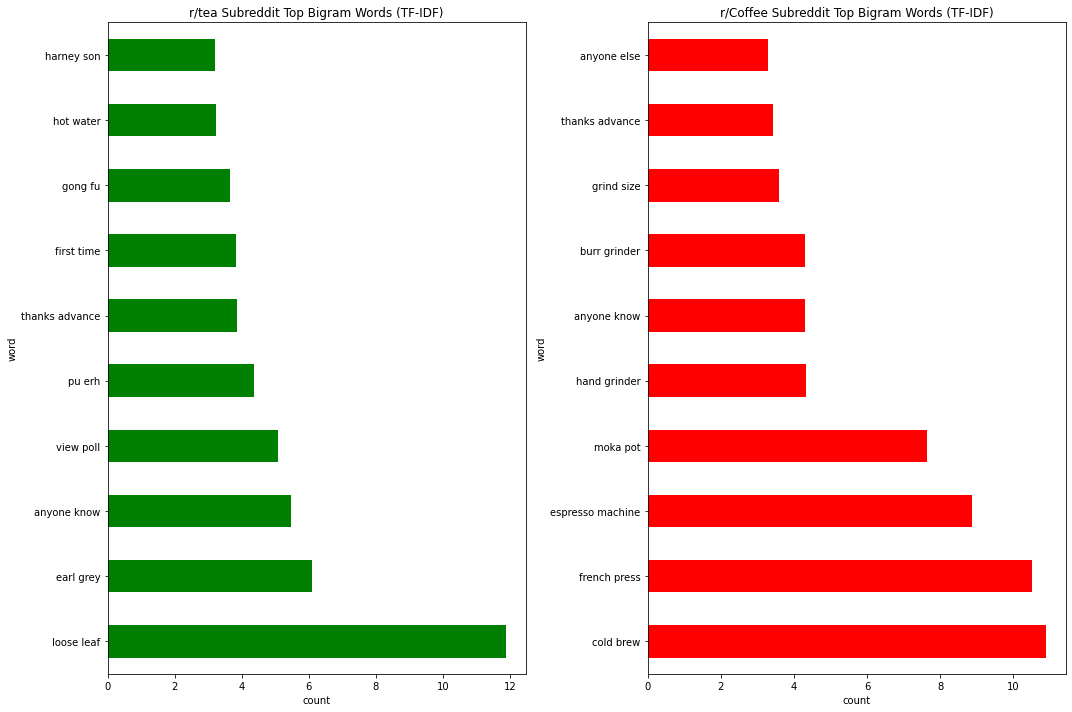

In [50]:
subplot_barplot(X_tea2, X_coffee2, 'r/tea', 'r/Coffee', (2,2), 'Bigram', 'tfidf')

##### + Trigram

The shape of the r/tea matrix : (1108, 42914)
The shape of the r/Coffee matrix : (1178, 53314)


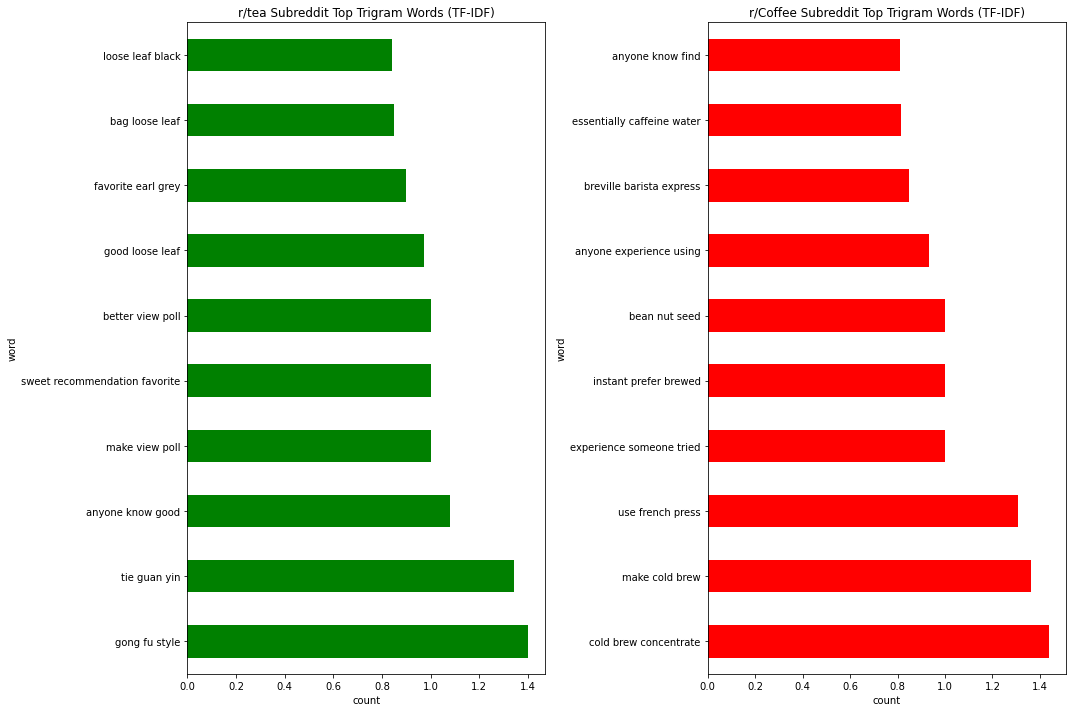

In [51]:
subplot_barplot(X_tea2, X_coffee2, 'r/tea', 'r/Coffee', (3,3), 'Trigram', 'tfidf')

Remarks: The top indicator words is similar as the Count Vectorizer for all unigram, bigram and trigram

## 4. Modelling

Let's set up our data for modeling:
- `X` will be the `text` column
- `y` will be the `subreddit` column

In [52]:
X = data_clean['text_cleaned_lemmatize_v2']
y = data_clean['subreddit']

### - Baseline Model

First, we will check the baseline model accuracy based on the value count of the subreddit category

In [53]:
# Check what we need to check in a classification problem.
y.value_counts(normalize= True)

1    0.515311
0    0.484689
Name: subreddit, dtype: float64

([<matplotlib.axis.YTick at 0x1da726089a0>,
 [Text(0, 0, 'r/Coffee'), Text(0, 1, 'r/tea')])

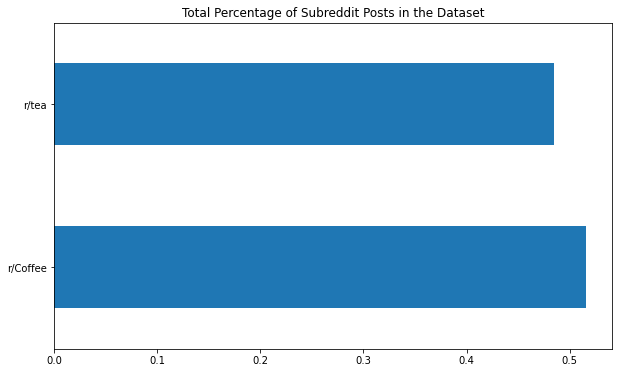

In [54]:
# Plot a bar graph of the value count
plt.rcParams['figure.figsize'] = 10,6
y.value_counts(normalize= True).plot(kind='barh')

plt.title('Total Percentage of Subreddit Posts in the Dataset')
plt.yticks([0,1], ['r/Coffee','r/tea'])

We can conclude that the accuracy of the baseline model will be **51.5311%**

### - Train Test Split

In [55]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

We will do multiple combination of modelling to determine which one has the best indicator, here are the following combinations:
1. Count Vectorizer / Multinomial Naive Bayes
2. TF-IDF / Multinomial Naive Bayes
3. Count Vectorizer/ Binomial Naive Bayes
4. TF-IDF / Binomial Naive Bayes
5. Count Vectorizer / Logistic Regression
6. TF-IDF / Logistic Regression

The process of the modelling as follow:
1. Insert the transformer and estimator model to a pipeline
2. Set the pipe parameters
3. Instantiate GridSearchCV to find the best parameters to be fitted
4. Fit the GridSearchCV fitted model with the train and test data to calculate the accuracy
5. Find the features importance of each subreddit
6. Plot a confusion matrix and ROC Curve

### 4.1 Count Vectorizer / Multinomial Naive Bayes

In [56]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [57]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Alpha for the laplace smoothing of the multinomial NB

pipe_params1 = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3), (2,2), (3,3)],
    'nb__alpha': [0.25, 0.5, 0.75, 1.0]
}

In [58]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe1, # what object are we optimizing?
                  param_grid=pipe_params1, # what parameters values are we searching?
                  cv=5, n_jobs=-1) # 5-fold cross-validation.

In [59]:
%%time
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

Wall time: 1min 27s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                               (3, 3)],
                         'nb__alpha': [0.25, 0.5, 0.75, 1.0]})

In [60]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 1.0}

In [61]:
print(gs.best_score_)

0.9052947563390177


In [62]:
# Score model on training set.
gs.score(X_train, y_train)

0.9673416067929458

In [63]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9139072847682119

In [64]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

**Features Importance**

In [65]:
nb_m1 = gs.best_estimator_.named_steps['nb']
cvec_m1 = gs.best_estimator_.named_steps['cvec']

In [213]:
from IPython.display import display_html

def FeaturesImportanceNB(trfmr, nb):
    df = pd.DataFrame()

    df['feature'] = trfmr.get_feature_names()
    df['log prob diff'] = nb.feature_log_prob_[1,:] - nb.feature_log_prob_[0, :]

    df_tea = df.sort_values(by= 'log prob diff', ascending= True).head(10)
    df_coffee = df.sort_values(by= 'log prob diff', ascending= False).head(10)

    caption1 = df_tea.style.set_table_attributes("style='display:inline'").set_caption('r/tea Features Importance')
    caption2 = df_coffee.style.set_table_attributes("style='display:inline'").set_caption('r/Coffee Features Importance')
    display_html(caption1._repr_html_()+'&emsp;&emsp;'+caption2._repr_html_(), raw=True)
    

In [172]:
# display the features importance of each subreddit
FeaturesImportanceNB(cvec_m1,nb_m1)

,feature,log prob diff
2396,oolong,-5.129162
2149,matcha,-4.813524
1990,leaf,-4.480140
2712,pu,-4.170639
1699,herbal,-4.170639
2073,loose,-4.088961
1151,earl,-4.023003
3477,teapot,-3.940115
1888,jasmine,-3.876399
2007,lemon,-3.794161


The features importance that is determine based on the model has the same trend as per our top indicator in the EDA part.  
For r/tea, we can see more type of tea coming out, such as oolong, matcha, pu (for pu erh), herbal, earl (for earl grey), jasmine, lemon  
For r/Coffee, the method and machine is still the important feature

In [68]:
def PlotROCCurve(clf, X=X_test, y=y_test): 
    y_pred_proba = clf.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    auc = roc_auc_score(y, y_pred_proba)

    plt.rcParams['figure.figsize'] = 10,6

    plt.plot(fpr,tpr,label="data, auc="+str(auc))
    plt.plot(["0", "1"], ["0", "1"], label='baseline', linestyle='--')

    plt.title("ROC Curve")
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')

    plt.legend(loc=4)

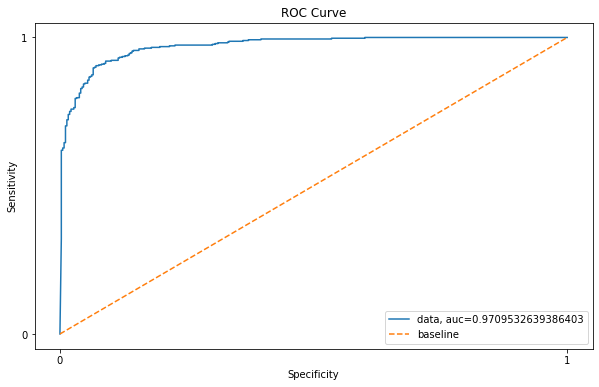

In [69]:
PlotROCCurve(gs)

Text(0.5, 1.0, 'Confusion Matrix of Count Vectorizer+ Multinomial NB')

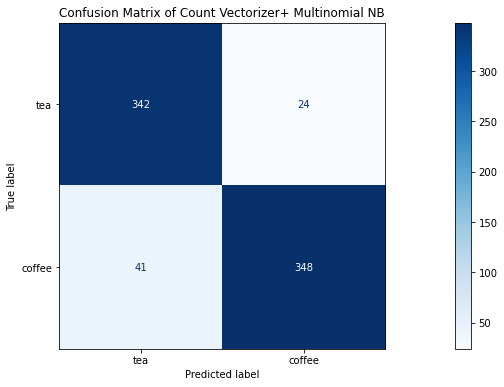

In [70]:
# View confusion matrix
plt.rcParams['figure.figsize'] = 25,6

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', display_labels=['tea','coffee'] , values_format='d')

plt.title('Confusion Matrix of Count Vectorizer+ Multinomial NB')

In [71]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       366
           1       0.94      0.89      0.91       389

    accuracy                           0.91       755
   macro avg       0.91      0.91      0.91       755
weighted avg       0.91      0.91      0.91       755



### 4.2 TF-IDF / Multinomial Naive Bayes

In [72]:
# Let's set a pipeline up with two stages:
# 1. TF-IDF (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [73]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Alpha for the laplace smoothing of the multinomial NB

pipe_params2 = {
    'tfidf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3), (2,2), (3,3)],
    'nb__alpha': [0.25, 0.5, 0.75, 1.0]
}

In [74]:
# Instantiate GridSearchCV.

gs2 = GridSearchCV(pipe2, # what object are we optimizing?
                  param_grid=pipe_params2, # what parameters values are we searching?
                  cv=5, n_jobs=-1) # 5-fold cross-validation.

In [75]:
%%time
# Fit GridSearch to training data.
gs2.fit(X_train, y_train)

Wall time: 1min 31s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.25, 0.5, 0.75, 1.0],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [2000, 3000, 4000, 5000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (3, 3)]})

In [76]:
gs2.best_params_

{'nb__alpha': 0.5,
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 4000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 1)}

In [77]:
print(gs2.best_score_)

0.8987630665729919


In [78]:
# Score model on training set.
gs2.score(X_train, y_train)

0.9810581319399085

In [79]:
# Score model on testing set.
gs2.score(X_test, y_test)

0.9139072847682119

In [80]:
# Get predictions
preds2 = gs2.predict(X_test)

# Save confusion matrix values
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds2).ravel()

**Features Importance**

In [81]:
nb_m2 = gs2.best_estimator_.named_steps['nb']
tfidf_m2 = gs2.best_estimator_.named_steps['tfidf']

In [82]:
# display the features importance of each subreddit
FeaturesImportanceNB(tfidf_m2,nb_m2)

,feature,log prob diff
1990,leaf,-3.605617
2396,oolong,-3.468610
2073,loose,-3.337991
2149,matcha,-3.324815
1600,green,-3.109481
1699,herbal,-2.927101
3477,teapot,-2.820677
1151,earl,-2.808009
1604,grey,-2.746131
2712,pu,-2.738472


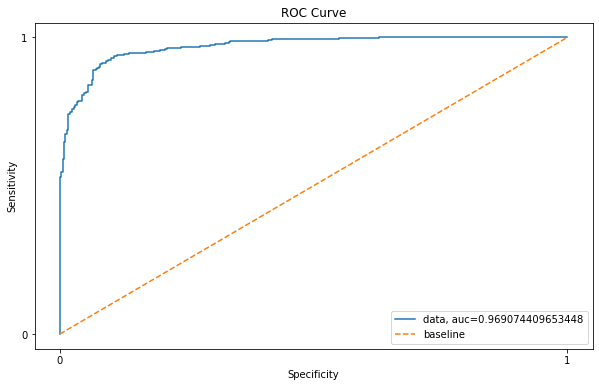

In [83]:
PlotROCCurve(gs2)

Text(0.5, 1.0, 'Confusion Matrix of TF-IDF+ Multinomial NB')

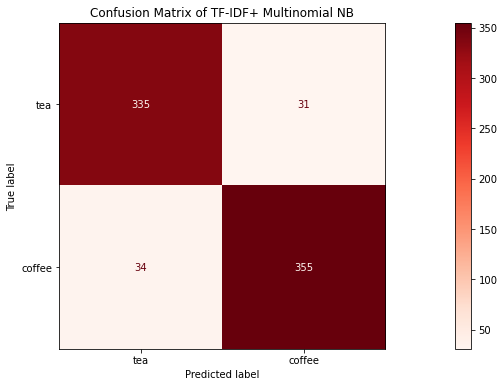

In [84]:
# View confusion matrix
plt.rcParams['figure.figsize'] = 25,6

plot_confusion_matrix(gs2, X_test, y_test, cmap='Reds', display_labels=['tea','coffee'] , values_format='d')

plt.title('Confusion Matrix of TF-IDF+ Multinomial NB')

In [85]:
print(classification_report(y_test, preds2))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       366
           1       0.92      0.91      0.92       389

    accuracy                           0.91       755
   macro avg       0.91      0.91      0.91       755
weighted avg       0.91      0.91      0.91       755



### 4.3 Count Vectorizer / Bernoulli Naive Bayes

In [86]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Bernoulli Naive Bayes (estimator)

pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [87]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Alpha for the laplace smoothing of the multinomial NB

pipe_params3 = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (2,2)],
    'bnb__alpha': [0.25, 0.5, 0.75, 1.0],
    'bnb__binarize': [0.25, 0.5, 0.75, 1.0]
}

In [88]:
# Instantiate GridSearchCV.

gs3 = GridSearchCV(pipe3, # what object are we optimizing?
                  param_grid=pipe_params3, # what parameters values are we searching?
                  cv=5, n_jobs=-1) # 5-fold cross-validation.

In [89]:
%%time
# Fit GridSearch to training data.
gs3.fit(X_train, y_train)

Wall time: 2min 42s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'bnb__alpha': [0.25, 0.5, 0.75, 1.0],
                         'bnb__binarize': [0.25, 0.5, 0.75, 1.0],
                         'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [90]:
gs3.best_params_

{'bnb__alpha': 0.25,
 'bnb__binarize': 0.25,
 'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [91]:
print(gs3.best_score_)

0.8674118072853464


In [92]:
# Score model on training set.
gs3.score(X_train, y_train)

0.9353363814500326

In [93]:
# Score model on testing set.
gs3.score(X_test, y_test)

0.8503311258278146

In [94]:
# Get predictions
preds3 = gs3.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

**Features Importance**

In [95]:
nb_m3 = gs3.best_estimator_.named_steps['bnb']
cvec_m3 = gs3.best_estimator_.named_steps['cvec']

In [96]:
# display the features importance of each subreddit
FeaturesImportanceNB(cvec_m3,nb_m3)

,feature,log prob diff
2396,oolong,-5.529437
2149,matcha,-5.091815
1699,herbal,-4.981358
1151,earl,-4.857168
2712,pu,-4.823551
672,chamomile,-4.636088
3908,yunnan,-4.550013
1516,gaiwan,-4.504028
1569,gong,-4.504028
706,china,-4.455826


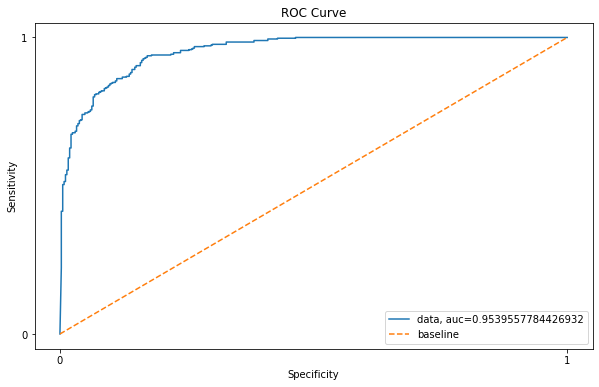

In [97]:
PlotROCCurve(gs3)

Text(0.5, 1.0, 'Confusion Matrix of Count Vectorizer + Bernoulli NB')

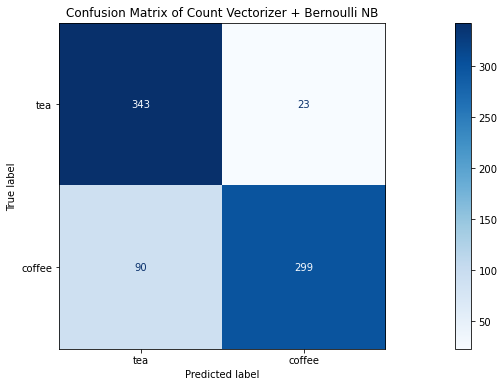

In [98]:
# View confusion matrix
plt.rcParams['figure.figsize'] = 25,6

plot_confusion_matrix(gs3, X_test, y_test, cmap='Blues', display_labels=['tea','coffee'] , values_format='d')

plt.title('Confusion Matrix of Count Vectorizer + Bernoulli NB')

In [99]:
print(classification_report(y_test, preds3))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       366
           1       0.93      0.77      0.84       389

    accuracy                           0.85       755
   macro avg       0.86      0.85      0.85       755
weighted avg       0.86      0.85      0.85       755



### 4.4 TF-IDF / Bernoulli Naive Bayes

In [100]:
# Let's set a pipeline up with two stages:
# 1. TF-IDF (transformer)
# 2. Bernoulli Naive Bayes (estimator)

pipe4 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [101]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Alpha for the laplace smoothing of the Bernoulli NB: 0.25, 0.5, 0.75, 1.0
# Binarize for the Bernoulli NB: 0.25, 0.5, 0.75, 1.0

pipe_params4 = {
    'tfidf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'bnb__alpha': [0.25, 0.5, 0.75, 1.0],
    'bnb__binarize': [0.25, 0.5, 0.75, 1.0]
}

In [102]:
# Instantiate GridSearchCV.

gs4 = GridSearchCV(pipe4, # what object are we optimizing?
                  param_grid=pipe_params4, # what parameters values are we searching?
                  cv=5, n_jobs=-1) # 5-fold cross-validation.

In [103]:
%%time
# Fit GridSearch to training data.
gs4.fit(X_train, y_train)

Wall time: 2min 45s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'bnb__alpha': [0.25, 0.5, 0.75, 1.0],
                         'bnb__binarize': [0.25, 0.5, 0.75, 1.0],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [2000, 3000, 4000, 5000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [104]:
gs4.best_params_

{'bnb__alpha': 0.75,
 'bnb__binarize': 0.25,
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2)}

In [105]:
print(gs4.best_score_)

0.8092801941623555


In [106]:
# Score model on training set.
gs4.score(X_train, y_train)

0.9418680600914435

In [107]:
# Score model on testing set.
gs4.score(X_test, y_test)

0.7774834437086092

In [108]:
# Get predictions
preds4 = gs4.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

**Features Importance**

In [109]:
nb_m4 = gs4.best_estimator_.named_steps['bnb']
tfidf_m4 = gs4.best_estimator_.named_steps['tfidf']

In [110]:
# display the features importance of each subreddit
FeaturesImportanceNB(tfidf_m4,nb_m4)

,feature,log prob diff
757,green,-3.557804
977,leaf,-3.516561
1087,matcha,-3.516561
1223,oolong,-3.332132
1733,teapot,-3.280173
1041,loose,-3.225364
823,herbal,-3.167377
1042,loose leaf,-3.040222
1648,steep,-2.894510
1887,view poll,-2.812832


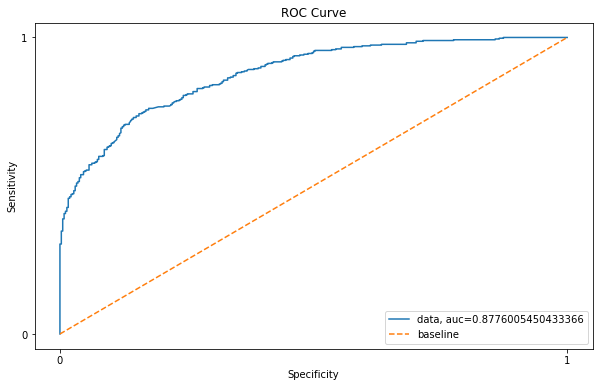

In [111]:
PlotROCCurve(gs4)

Text(0.5, 1.0, 'Confusion Matrix of TF-IDF + Bernoulli NB')

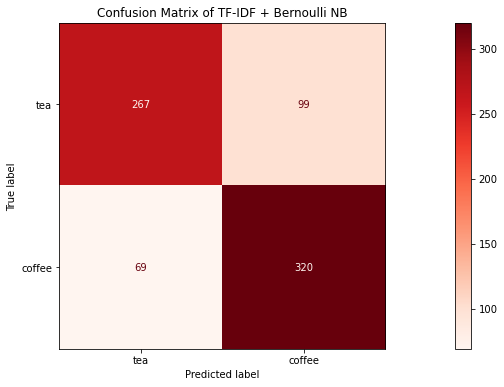

In [112]:
# View confusion matrix
plt.rcParams['figure.figsize'] = 25,6

plot_confusion_matrix(gs4, X_test, y_test, cmap='Reds', display_labels=['tea','coffee'] , values_format='d')

plt.title('Confusion Matrix of TF-IDF + Bernoulli NB')

In [113]:
print(classification_report(y_test, preds4))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       366
           1       0.76      0.82      0.79       389

    accuracy                           0.78       755
   macro avg       0.78      0.78      0.78       755
weighted avg       0.78      0.78      0.78       755



### 4.5 Count Vectorizer / Logistic Regression

In [114]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Logistic Regression (estimator)

pipe5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [115]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Alpha for the laplace smoothing of the multinomial NB

pipe_params5 = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (2,2)],
    'logreg__C': np.logspace(-2,2,50),
    'logreg__penalty': ['l1','l2'],
    'logreg__solver': ['liblinear']
}

In [116]:
# Instantiate GridSearchCV.

gs5 = GridSearchCV(pipe5, # what object are we optimizing?
                  param_grid=pipe_params5, # what parameters values are we searching?
                  cv=5, n_jobs=-1) # 5-fold cross-validation.

In [117]:
%%time
# Fit GridSearch to training data.
gs5.fit(X_train, y_train)

Wall time: 16min 50s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'logreg__C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02...
       1.93069773e+00, 2.32995181e+00, 2.81176870e+00, 3.39322177e+00,
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
                         'logreg__pe

In [118]:
gs5.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'logreg__C': 0.09540954763499938,
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear'}

In [119]:
print(gs5.best_score_)

0.8772072129611889


In [120]:
# Score model on training set.
gs5.score(X_train, y_train)

0.9804049640757675

In [121]:
# Score model on testing set.
gs5.score(X_test, y_test)

0.8728476821192053

In [122]:
# Get predictions
preds5 = gs5.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds5).ravel()

In [123]:
logreg_m5 = gs5.best_estimator_.named_steps['logreg']
cvec_m5 = gs5.best_estimator_.named_steps['cvec']

In [124]:
def FeaturesImportanceLogReg(trfmr, lr):
    df = pd.DataFrame()

    df['feature'] = trfmr.get_feature_names()
    df['coef'] = lr.coef_.reshape(-1)

    df_tea = df.sort_values(by= 'coef', ascending= True).head(10)
    df_coffee = df.sort_values(by= 'coef', ascending= False).head(10)

    caption1 = df_tea.style.set_table_attributes("style='display:inline'").set_caption('r/tea Features Importance')
    caption2 = df_coffee.style.set_table_attributes("style='display:inline'").set_caption('r/Coffee Features Importance')
    display_html(caption1._repr_html_()+'&emsp;&emsp;'+caption2._repr_html_(), raw=True)
    

In [125]:
FeaturesImportanceLogReg(cvec_m5,logreg_m5)

,feature,coef
1540,leaf,-0.950821
1231,green,-0.837500
1660,matcha,-0.577634
1608,loose,-0.475148
1843,oolong,-0.462009
1308,herbal,-0.452882
522,chai,-0.443759
2656,teapot,-0.443370
2522,steep,-0.395352
291,bag,-0.386590


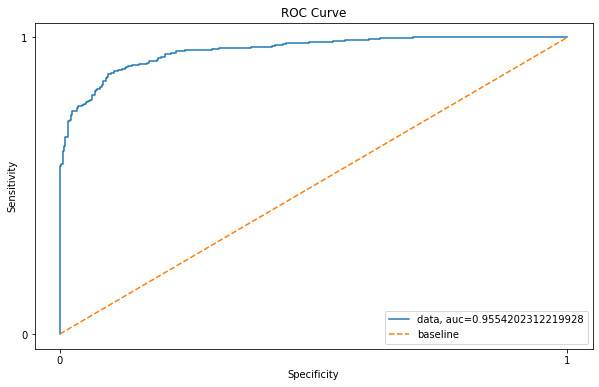

In [126]:
PlotROCCurve(gs5)

Text(0.5, 1.0, 'Confusion Matrix of Count Vectorizer + Logistic Regression')

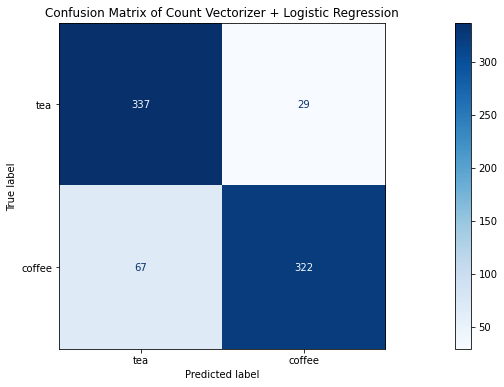

In [127]:
# View confusion matrix
plt.rcParams['figure.figsize'] = 25,6

plot_confusion_matrix(gs5, X_test, y_test, cmap='Blues', display_labels=['tea','coffee'] , values_format='d')

plt.title('Confusion Matrix of Count Vectorizer + Logistic Regression')

In [128]:
print(classification_report(y_test, preds5))

              precision    recall  f1-score   support

           0       0.83      0.92      0.88       366
           1       0.92      0.83      0.87       389

    accuracy                           0.87       755
   macro avg       0.88      0.87      0.87       755
weighted avg       0.88      0.87      0.87       755



### 4.6 TF-IDF / Logistic Regression

In [132]:
# Let's set a pipeline up with two stages:
# 1. TF-IDF (transformer)
# 2. Logistic Regression (estimator)

pipe6 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [133]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Alpha for the laplace smoothing of the multinomial NB

pipe_params6 = {
    'tfidf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'logreg__C': np.logspace(-2,2,50),
    'logreg__penalty': ['l1','l2'],
    'logreg__solver': ['liblinear']
}

In [134]:
# Instantiate GridSearchCV.

gs6 = GridSearchCV(pipe6, # what object are we optimizing?
                  param_grid=pipe_params6, # what parameters values are we searching?
                  cv=5, n_jobs=-1) # 5-fold cross-validation.

In [136]:
%%time
# Fit GridSearch to training data.
gs6.fit(X_train, y_train)

Wall time: 15min 24s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.151395...
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear'],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [2000, 3000, 4000, 5000],
                         'tf

In [137]:
gs6.best_params_

{'logreg__C': 0.9102981779915218,
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear',
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 3000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2)}

In [138]:
print(gs6.best_score_)

0.8928785846586191


In [139]:
# Score model on training set.
gs6.score(X_train, y_train)

0.9797517962116263

In [140]:
# Score model on testing set.
gs6.score(X_test, y_test)

0.8940397350993378

In [141]:
# Get predictions
preds6 = gs6.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds6).ravel()

In [142]:
logreg_m6 = gs6.best_estimator_.named_steps['logreg']
tfidf_m6 = gs6.best_estimator_.named_steps['tfidf']

In [143]:
FeaturesImportanceLogReg(tfidf_m6,logreg_m6)

,feature,coef
1492,leaf,-3.398817
1172,green,-2.794190
1669,matcha,-2.139168
1849,oolong,-1.980654
1582,loose,-1.815573
2608,teapot,-1.717363
1583,loose leaf,-1.557966
346,black,-1.486418
1280,herbal,-1.476345
2493,steep,-1.407911


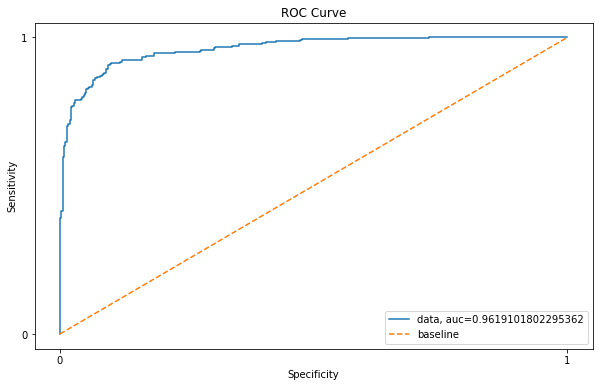

In [144]:
PlotROCCurve(gs6)

Text(0.5, 1.0, 'Confusion Matrix of TF-IDF + Logistic Regression')

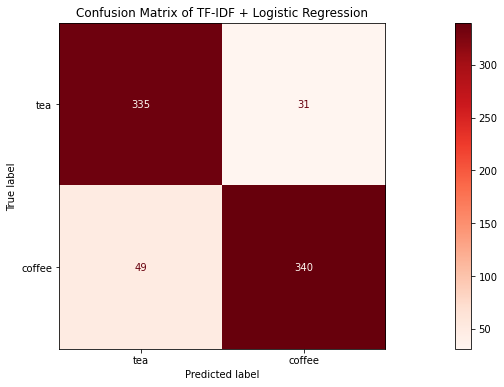

In [145]:
# View confusion matrix
plt.rcParams['figure.figsize'] = 25,6

plot_confusion_matrix(gs6, X_test, y_test, cmap='Reds', display_labels=['tea','coffee'] , values_format='d')

plt.title('Confusion Matrix of TF-IDF + Logistic Regression')

In [146]:
print(classification_report(y_test, preds6))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       366
           1       0.92      0.87      0.89       389

    accuracy                           0.89       755
   macro avg       0.89      0.89      0.89       755
weighted avg       0.90      0.89      0.89       755



## 5. Conclusion

### - Summary

After running all the model, below are the summary table of the accuracy score:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky" colspan="2">Multinomial NB</th>
    <th class="tg-0pky" colspan="2">Bernoulli NB</th>
    <th class="tg-0pky" colspan="2">Logistic Regression</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax"></td>
    <td class="tg-0lax">Count Vectorizer</td>
    <td class="tg-0lax">TF-IDF Vectorizer</td>
    <td class="tg-0lax">Count Vectorizer</td>
    <td class="tg-0lax">TF-IDF Vectorizer</td>
    <td class="tg-0lax">Count Vectorizer</td>
    <td class="tg-0lax">TF-IDF Vectorizer</td>
  </tr>
  <tr>
    <td class="tg-0pky">CV Score</td>
    <td class="tg-0pky">0.905294756</td>
    <td class="tg-0pky">0.898763067</td>
    <td class="tg-0pky">0.867411807</td>
    <td class="tg-0pky">0.809280194</td>
    <td class="tg-0pky">0.877207213</td>
    <td class="tg-0pky">0.892878585</td>  
  </tr>
  <tr>
    <td class="tg-0pky">Train Score</td>
    <td class="tg-0pky">0.967341607</td>
    <td class="tg-0pky">0.981058132</td>
    <td class="tg-0pky">0.935336381</td>
    <td class="tg-0pky">0.941868060</td>
    <td class="tg-0pky">0.980404964</td>
    <td class="tg-0pky">0.979751796</td>
  </tr>
  <tr>
    <td class="tg-0pky">Test Score</td>
    <td class="tg-0pky">0.913907285</td>
    <td class="tg-0pky">0.913907285</td>
    <td class="tg-0pky">0.850331126</td>
    <td class="tg-0pky">0.777483444</td>
    <td class="tg-0pky">0.872847682</td>
     <td class="tg-0pky">0.894039735</td>
  </tr>
</tbody>
</table>

The pipeline that we tested fair quite good as they have CV score higher than 0.80. It has an improvement of at least 30% from the baseline model accuracy.

As for this project, we consider the accuracy is the most important metrics that need to be analysed. Based on the CV score, we conclude that the Count Vectorizer with Multionomial Naive Bayes is the best model. It has the highest test score (it is the same as the TF-IDF Vecotrizer with Multinomial NB model). The other reason this is the best model, we can see the difference between the train score and test score is the lowest, this model overfitting is lesser than other models.  

The AUC score for every models remains high at around 0.95 but our model still has the best AUC.

In [214]:
FeaturesImportanceNB(cvec_m1,nb_m1)

,feature,log prob diff
2396,oolong,-5.129162
2149,matcha,-4.813524
1990,leaf,-4.480140
2712,pu,-4.170639
1699,herbal,-4.170639
2073,loose,-4.088961
1151,earl,-4.023003
3477,teapot,-3.940115
1888,jasmine,-3.876399
2007,lemon,-3.794161


The top 5 most important features for r/tea are:
- oolong
- matcha
- leaf
- pu
- herbal

The top 5 most important features for r/Coffee are:
- grinder
- espresso
- burr
- bean
- v60

### - Recommendation

1. Built the recommended system with top keywords and other related words
2. Maintain the inventory based on the trend provided from the analysis to have a greater supply chain effectiveness
3. Offer additional offerings that is related to the top keywords, such as matcha latte, RTD espresso

### - Limitations

1. Misspelled words is not addressed thus it may fall out of context
2. Multi-words names of tea, beans, and their equipments are not addressed properly. Important terms that do not make sense as individual words such as pu erh or earl grey. 
3. Small stopword list, allow common words that has little relevant to tea and coffee to be included in the modelling
4. Text analysis only, does not include image and video analysis
5. Small datasets with only 1000s posts per subreddit
6. Reddit may have only posts mainly from US residents, other region remained untouched

### - Future Works

1. Analysis of other social media platforms that may have bigger scope of global users
2. Analysis of forum of social media with other languages
3. Feature Engineering based on the parameter obtain from the scraped data and other type of data
4. Analysis of other form of data such as image and video
5. Scrape more data from the subreddit to be analysed further